# Setup
1. In colab: Go to "Runtime" -> "Change runtime type" -> Select "T4 GPU"
2. Install TerraTorch

In [ ]:
!pip install gdown tensorboard

In [2]:
import torch
import gdown
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import os
import zipfile

warnings.filterwarnings('ignore')

3. Download the dataset from Google Drive

In [3]:
if not os.path.isfile('granite-geospatial-biomass-dataset.zip'):
    gdown.download("https://drive.google.com/uc?id=1s0i_gGL8_zWha3V3yV2MGCPg20YL2y96")
    
if not os.path.isdir('granite-geospatial-biomass-dataset/'):
    with zipfile.ZipFile('granite-geospatial-biomass-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('granite-geospatial-biomass-dataset')

## AGB Dataset

Lets start with analyzing the dataset

In [4]:
dataset_path = Path('granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset')
!ls "granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset"

test_images  test_labels  train_images train_labels val_images   val_labels


In [5]:
!ls "granite-geospatial-biomass-dataset/granite-geospatial-biomass-dataset/train_images/" | head

T11UPT_128_tile_img.tif
T11UPT_129_tile_img.tif
T11UPT_130_tile_img.tif
T11UPT_132_tile_img.tif
T11UPT_133_tile_img.tif
T11UPT_136_tile_img.tif
T11UPT_138_tile_img.tif
T11UPT_139_tile_img.tif
T11UPT_141_tile_img.tif
T11UPT_142_tile_img.tif


In [6]:
from terratorch.datamodules import GenericNonGeoPixelwiseRegressionDataModule

datamodule = GenericNonGeoPixelwiseRegressionDataModule(
    batch_size=4,
    num_workers=2,
    num_classes=2,
    check_stackability = False,
    # Define dataset paths 
    train_data_root=dataset_path / 'train_images/',
    train_label_data_root=dataset_path / 'train_labels/',
    val_data_root=dataset_path / 'val_images/',
    val_label_data_root=dataset_path / 'val_labels/',
    test_data_root=dataset_path / 'test_images/',
    test_label_data_root=dataset_path / 'test_labels/',
    
    img_grep='*.tif',
    label_grep='*.tif',
    
    train_transform=[
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
        
    # Define standardization values
    means=[
      547.36707,
      898.5121,
      1020.9082,
      2665.5352,
      2340.584,
      1610.1407,
    ],
    stds=[
      411.4701,
      558.54065,
      815.94025,
      812.4403,
      1113.7145,
      1067.641,
    ],
    dataset_bands = [-1, "BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2", -1, -1, -1, -1],
    output_bands = ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    rgb_indices = [2, 1, 0],
    no_data_replace=0,
    no_label_replace=-1,
)

# Setup train and val datasets
datamodule.setup("fit")

In [7]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

1622

In [8]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

406

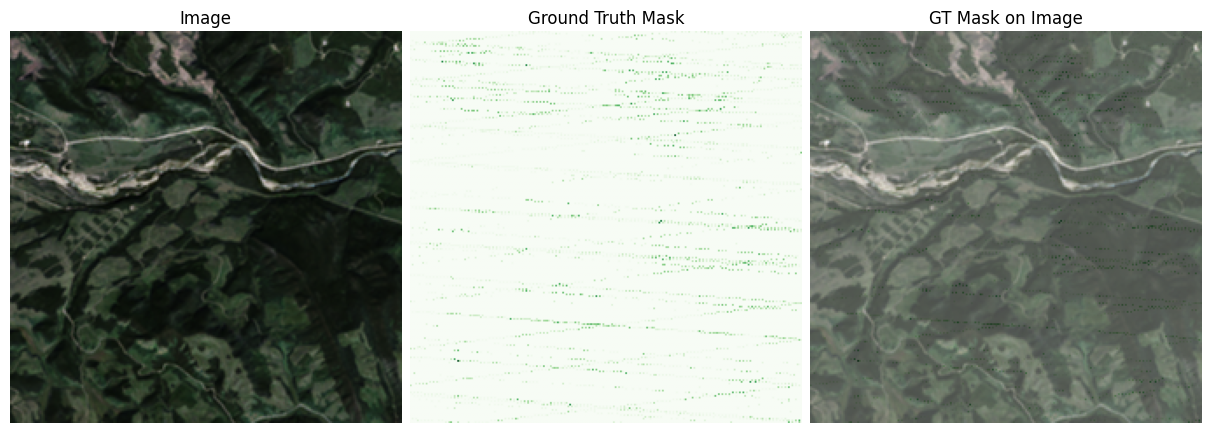

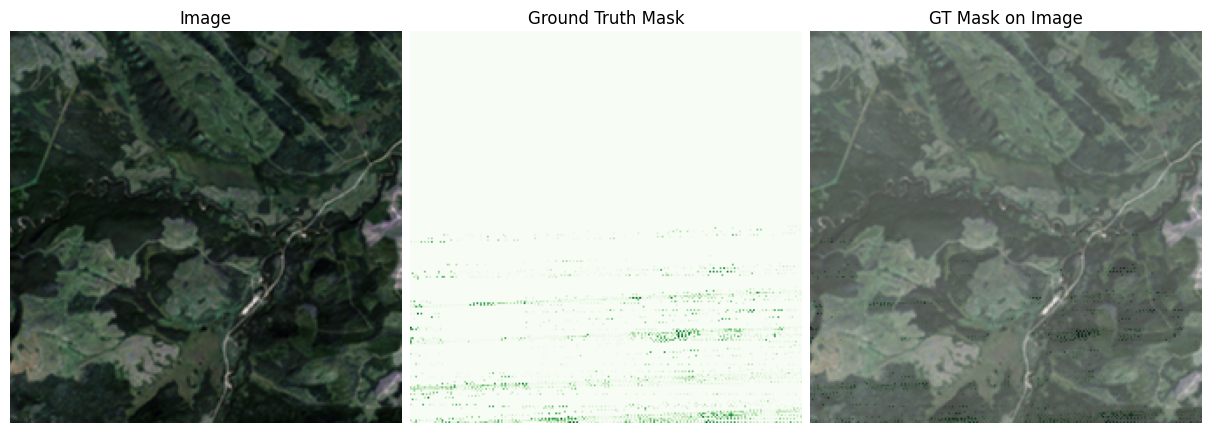

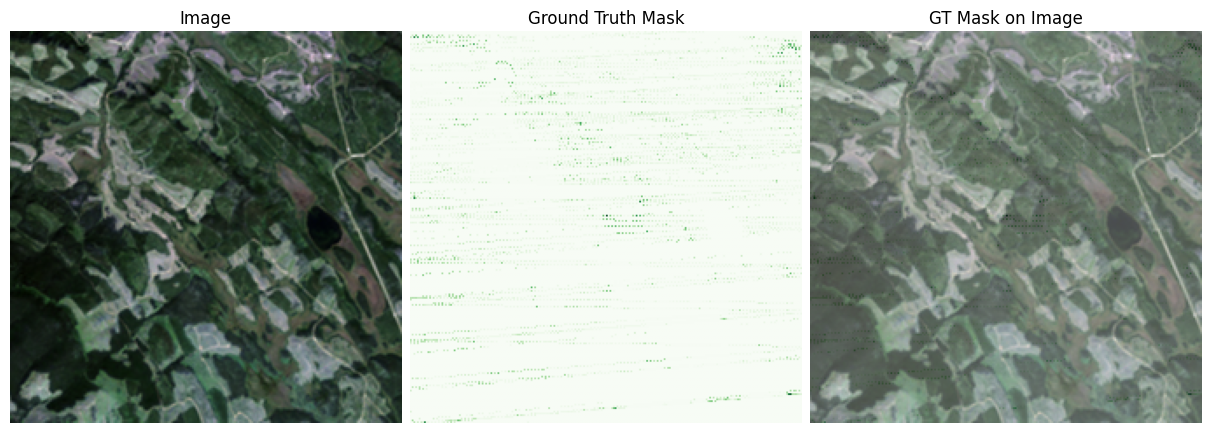

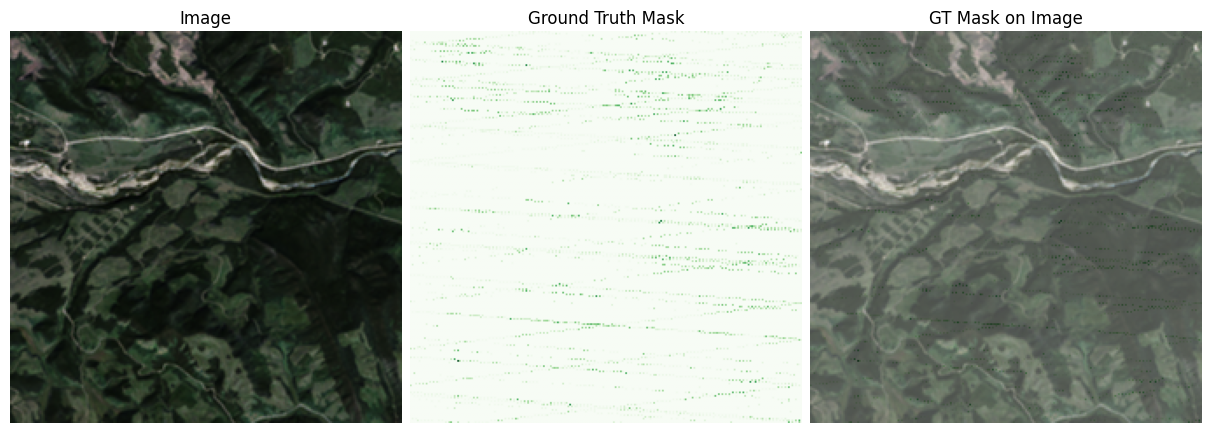

In [9]:
# plotting a few samples
val_dataset.plot(val_dataset[0])
val_dataset.plot(val_dataset[6])
val_dataset.plot(val_dataset[10])

In [10]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

360

# Fine-tune Prithvi

In [ ]:
from terratorch.tasks import PixelwiseRegressionTask

pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/agb/checkpoints/",
    mode="min",
    monitor="val/RMSE", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/agb",
    detect_anomaly=True,
)

# Model
model = PixelwiseRegressionTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_pretrained": True,
        "backbone_num_frames": 1, # 1 is the default value,
        # "backbone_img_size": 224,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        # "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
        
        # Necks 
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {"name": "ReshapeTokensToImage",},
            {"name": "LearnedInterpolateToPyramidal"}            
        ],
        
        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],
        # "head_dropout": 0.16194593880230534,
        # "head_final_act": torch.nn.ReLU,
        # "head_learned_upscale_layers": 2
    },
    
    loss="rmse",
    optimizer="AdamW",
    lr=1e-3,
    ignore_index=-1,
    freeze_backbone=True, # Only to speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
)

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

In [15]:
best_ckpt_path = "output/agb/checkpoints/best-epoch=00.ckpt"

In [16]:
def run_test_and_visual_inspection(model, ckpt_path):

    # let's run the model on the test set
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # now we can use the model for predictions and plotting!
    model = terratorch.tasks.PixelwiseRegressionTask.load_from_checkpoint(
    ckpt_path,
    model_factory=model.hparams.model_factory,
    model_args=model.hparams.model_args,
    )
    
    test_loader = datamodule.test_dataloader()
    with torch.no_grad():
        batch = next(iter(test_loader))
        images = datamodule.aug(batch)
        images = batch["image"].to(model.device)
        
        masks = batch["mask"].numpy()
    
        preds = model(images).output
    
    for i in range(4):
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[i].cpu()
        sample["image"] = sample["image"].cpu()
        sample["mask"] = sample["mask"].cpu()
        test_dataset.plot(sample)

In [ ]:
run_test_and_visual_inspection(model, best_ckpt_path)

In [ ]:
best_ckpt_100_epoch_path = "agb_best-epoch=68.ckpt"

if not os.path.isfile(best_ckpt_100_epoch_path):
    gdown.download("https://drive.google.com/uc?id=1ACjb4oWb2p_ZA87TQcuSWvCcB4_61fA-")


In [ ]:
run_test_and_visual_inspection(model, best_ckpt_100_epoch_path)

# Fine-tuning via CLI

You might want to restart the session to free up GPU memory.

In [ ]:
# Run fine-tuning
!terratorch fit -c configs/prithvi_v2_eo_300_tl_unet_agb.yaml